In [1]:
from pyspark import SparkConf, SparkContext
import apache_log_parser as parser
import re

In [2]:
data_location = "file:///home/hatef/courses/term-4/hw3/Datasets/2/Log"
conf = SparkConf().setMaster("local[*]").setAppName("one")
sc = SparkContext(conf = conf).getOrCreate()

In [3]:
inp = sc.textFile(data_location)
line_parser = parser.make_parser("%h %t \"%r\" %>s %b")

In [4]:
print(inp.take(4))

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245', 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985', '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085', 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0']


In [1]:
### for log parsing we use a github parser called apache_log_parser and configure it like this:
### parser.make_parser("%h %t \"%r\" %>s %b") if our parsing throws exception for each line we convert that line 
### to a dummy line!

In [5]:
def parse_log(text):
    try:
        parsed_line = line_parser(text)
        remote_host = parsed_line['remote_host'][:-4]
        request_datetime = str(parsed_line['time_received_datetimeobj'])
        status = str(parsed_line['status'])
        request_url = parsed_line['request_url'].lower()
        return (remote_host, status, request_url, request_datetime)
    except Exception:
        return ("dummy", "dummy", "dummy", "dummy")

In [6]:
data = inp.map(parse_log)

In [7]:
data.take(1)

[('199.72.81.55', '200', '/history/apollo/', '1995-07-01 00:00:01')]

In [8]:
unique_hosts = data.map(lambda x: x[0]).distinct()

In [9]:
unique_hosts.take(5)

['unicomp6.unicomp.net',
 '129.94.144.152',
 'ppptky391.asahi-net.or.jp',
 'slip1.yab.com',
 'pm13.j51.com']

In [10]:
print(unique_hosts.count())

81983


In [23]:
### part 2

In [11]:
import datetime

In [12]:
host_time = data.filter(lambda x: x[0] != "dummy")\
.map(lambda x: ((x[0], x[3][:10]), 1)).reduceByKey(lambda x, y: x + y)

In [13]:
host_time.take(4)
### in host_time rdd we have ((ip, day), number of visits in that day)

[(('199.120.110.21', '1995-07-01'), 3),
 (('205.212.115.106', '1995-07-01'), 7),
 (('smyth-pc.moorecap.com', '1995-07-01'), 9),
 (('scheyer.clark.net', '1995-07-01'), 2)]

In [14]:
avg_host_time = host_time.map(lambda x: (x[0][0], (x[1], 1))).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

In [15]:
avg_host_time.take(4)

# ip , (totalvisit, totaldays)

[('usr7-dialup46.chicago.mci.net', (1, 1)),
 ('isdn6-34.dnai.com', (22, 2)),
 ('ix-ftw-tx1-24.ix.netcom.com', (8, 2)),
 ('citynet.ci.la.ca.us', (49, 4))]

In [16]:
final_avg_host_time = avg_host_time.mapValues(lambda x: x[0]/x[1])

In [17]:
final_avg_host_time.take(10)

[('usr7-dialup46.chicago.mci.net', 1.0),
 ('isdn6-34.dnai.com', 11.0),
 ('ix-ftw-tx1-24.ix.netcom.com', 4.0),
 ('citynet.ci.la.ca.us', 12.25),
 ('ppp5.earthlight.co.nz', 7.666666666666667),
 ('199.2.253.2', 1.0),
 ('ad08-027.compuserve.com', 15.0),
 ('sos.wingham.com', 12.0),
 ('slip-774.netaxs.com', 5.0),
 ('slper1p08.ozemail.com.au', 6.25)]

In [12]:
### part 3

In [18]:
gif_rdd = data.map(lambda x: x[2]).filter(lambda x: x.endswith(".gif") or x.endswith(".GIF"))

In [19]:
print(gif_rdd.take(5))

['/shuttle/missions/sts-73/sts-73-patch-small.gif', '/images/nasa-logosmall.gif', '/shuttle/countdown/video/livevideo.gif', '/shuttle/countdown/count.gif', '/images/nasa-logosmall.gif']


In [20]:
print(gif_rdd.count())

1043869


In [62]:
### part 4

In [21]:
### we exclude ip address with this regex and apply the similar logic in quesion 2
expression = re.compile('^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$')
most_wanted_hosts = data.filter(lambda x: not expression.match(x[0])).map(lambda x: ((x[0], x[3][:10]), 1)).reduceByKey(lambda x, y: x + y)

In [22]:
print(most_wanted_hosts.take(5))

# ((host name, day), visited on that day)

[(('smyth-pc.moorecap.com', '1995-07-01'), 9), (('scheyer.clark.net', '1995-07-01'), 2), (('remote27.compusmart.ab.ca', '1995-07-01'), 15), (('port2.electrotex.com', '1995-07-01'), 4), (('usr7-dialup46.chicago.mci.net', '1995-07-01'), 1)]


In [23]:
most = most_wanted_hosts.map(lambda x: (x[0][1], (x[0][0], x[1])))\
.reduceByKey(lambda x, y: (x[0], x[1]) if x[1] > y[1] else (y[0], y[1])).sortBy(lambda x: x[1][1])

In [26]:
most.take(20)

[('dummy', ('dummy', 1)),
 ('1995-07-27', ('edams.ksc.nasa.gov', 283)),
 ('1995-07-26', ('piweba3y.prodigy.com', 312)),
 ('1995-07-24', ('edams.ksc.nasa.gov', 336)),
 ('1995-07-28', ('pcmas.it.bton.ac.uk', 353)),
 ('1995-07-10', ('e659229.boeing.com', 358)),
 ('1995-07-18', ('siltb10.orl.mmc.com', 518)),
 ('1995-07-09', ('alyssa.prodigy.com', 545)),
 ('1995-07-01', ('piweba3y.prodigy.com', 623)),
 ('1995-07-22', ('currypc.fpl.msstate.edu', 700)),
 ('1995-07-23', ('currypc.fpl.msstate.edu', 709)),
 ('1995-07-06', ('piweba3y.prodigy.com', 732)),
 ('1995-07-25', ('jbiagioni.npt.nuwc.navy.mil', 763)),
 ('1995-07-08', ('piweba3y.prodigy.com', 781)),
 ('1995-07-05', ('news.ti.com', 826)),
 ('1995-07-19', ('siltb10.orl.mmc.com', 847)),
 ('1995-07-17', ('siltb10.orl.mmc.com', 850)),
 ('1995-07-07', ('piweba3y.prodigy.com', 879)),
 ('1995-07-20', ('siltb10.orl.mmc.com', 884)),
 ('1995-07-02', ('piweba3y.prodigy.com', 960))]

In [18]:
### part 5

In [31]:
errors = data.map(lambda x: x[1]).filter(lambda x: x != "200" and x != "dummy").countByValue()

In [32]:
print(errors)

defaultdict(<class 'int'>, {'304': 132627, '302': 46573, '404': 10845, '403': 54, '500': 62, '501': 14, '400': 5})


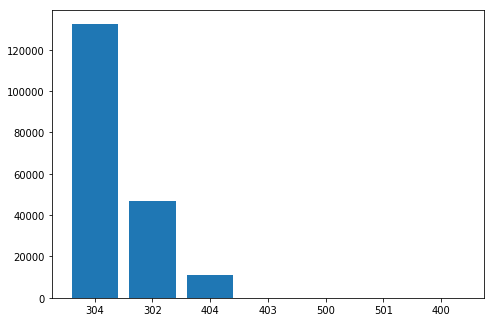

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
err = []
cnt = []
for e, c in errors.items():
    err.append(e)
    cnt.append(c)
ax.bar(err,cnt)
plt.show()